In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.colors as clr
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.patheffects as path_effects
from scanpy import tools
from scanpy.neighbors import Neighbors, OnFlySymMatrix
import dendropy

import matplotlib.cm as cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap, to_hex, Normalize
%matplotlib inline
import scanpy.api as sc
import math
import random
from scipy import stats
from timeit import timeit
from itertools import combinations

sns.set(style='white', palette='Set2', font_scale=1.2)

In [5]:
### Load the data, do some basic preprocessing, and compute the neighbor graph. 
### These would need to be computed once on loading.

rawdata = sc.read('./data/Marrow-counts.csv').transpose() # read in data
cell_annotation = pd.read_csv('./data/annotations_FACS.csv', index_col=0) # attach metadata
rawdata.obs['cell_type'] = cell_annotation.cell_ontology_class
adata = sc.pp.recipe_seurat(rawdata, copy=True) ## normalize; we could assume this is pre-run before loading
print('data shape:\n', adata.X.shape) # dataset size
sc.pp.pca(adata) # run PCA
print('\n\ncomputing neighbor graph:')
%time sc.pp.neighbors(adata, metric='euclidean', method='umap') # compute neighbor graph

data shape:
 (5242, 402)


computing neighbor graph:
CPU times: user 3.85 s, sys: 627 ms, total: 4.47 s
Wall time: 4.24 s


In [6]:
print('precomputing the neighbor graph buys us a lot of computation for free (<1 second). e.g., computing clusters:')
%time sc.tl.louvain(adata)
print('''NOTE: I need to investigate in more detail whether it's valid to use just PART of a 
precomputed neighbor graph for a subselection, as opposed to recomputing the neighbor graph upon subselection.
Stay tuned.''')

precomputing the neighbor graph buys us a lot of computation for free. e.g., computing clusters:
CPU times: user 653 ms, sys: 18.1 ms, total: 671 ms
Wall time: 689 ms
NOTE: I need to investigate in more detail whether it's valid to use just PART of a 
precomputed neighbor graph for a subselection, as opposed to recomputing the neighbor graph upon subselection.
Stay tuned.


In [51]:
## Compute all the layout options with default params; see ../scanpy-method-profiling.ipynb for params to expose to user
print('tsne')
%time sc.tl.tsne(adata) # tsne

print("\n\numap: note that THIS DEPENDS ON SC.PP.NEIGHBORS BEING RUN WITH METHOD='UMAP'")
%time sc.tl.umap(adata)

print("\n\ndiffmap: note that THIS DEPENDS ON SC.PP.NEIGHBORS (either method='umap' or 'gauss' is fine, but should be noted)")
%time sc.tl.diffmap(adata)

## scanpy calls almost exactly these three lines in sc.tl.phate, 
## but for some reason that implementation never completes / runs forever. 
import phate 
phate_operator = phate.PHATE(gamma=0)
print('''\n\nphate: note that this does something SIMILAR to diffmap, 
but it recomputes everything from the raw data. 
This turns out to be somewhat necessary (they have a few cute mathematical quirks in there that make a difference), 
and the difference in speed to reuse neighbors this vs. compute from scratch (~4-5s) is 
negligible given the overall timescale of ~1 min. [See bottom-ish cell]''')
%time phate_coordinates = phate_operator.fit_transform(adata.X)
adata.obsm['X_phate'] = phate_coordinates


tsne
CPU times: user 28.7 s, sys: 174 ms, total: 28.8 s
Wall time: 28.9 s


umap: note that THIS DEPENDS ON SC.PP.NEIGHBORS BEING RUN WITH METHOD='UMAP'
CPU times: user 7.5 s, sys: 44 ms, total: 7.55 s
Wall time: 7.65 s


diffmap: note that THIS DEPENDS ON SC.PP.NEIGHBORS (either method='umap' or 'gauss' is fine, but should be noted)
CPU times: user 143 ms, sys: 8.77 ms, total: 151 ms
Wall time: 138 ms


phate: note that this does something SIMILAR to diffmap, 
but it recomputes everything from the raw data. 
This turns out to be somewhat necessary (they have a few cute mathematical quirks in there that make a difference), 
and the difference in speed to reuse neighbors this vs. compute from scratch (~4-5s) is 
negligible given the overall timescale of ~1 min. [See bottom-ish cell]
Calculating PHATE...
Calculating graph and diffusion operator...
Calculating PCA...
Calculated PCA in 0.17 seconds.
Calculating KNN search...
Calculated KNN search in 3.44 seconds.
Calculating affinities...


In [52]:
print('Running paga (finding minimum spanning tree between categorical levels)')
%time sc.tl.paga(adata, groups='cell_type')
print('\n\nTo compute pseudotime, need to manually select a "root" cell')
root_idx = random.choice(np.where(adata.obs['cell_type'] == 'hematopoietic stem cell')[0])
adata.uns['iroot'] = root_idx
%time sc.tl.dpt(adata)

Running paga (finding minimum spanning tree between categorical levels)
CPU times: user 162 ms, sys: 18.5 ms, total: 180 ms
Wall time: 182 ms


To compute pseudotime, need to manually select a "root" cell
CPU times: user 2.2 ms, sys: 12 µs, total: 2.22 ms
Wall time: 2.22 ms


In [53]:
#### Plotting utils

def assign_colors(vals, cmap='Set2'):
    ''' return a dictionary of { value: (R,G,B,a) } '''
    na_vals = ['nan', 'NaN', 'N/A', np.nan, None]
    if type(cmap) == str:
        cmap = cm.get_cmap(cmap)
        
    mappable_vals = sorted(list(set([v for v in vals if v not in na_vals])))
    nvals = len(mappable_vals)
    
    colors = [cmap(i/nvals) for i in range(nvals)]
    colors = { val: colors[i] for i,val in enumerate(mappable_vals) }
    
    for v in vals:
        if v in na_vals:
            colors.update({v: 'gray'})
    
    return colors

def find_group_center(adata, x, y, group_key, group):
    group_indices = np.where(adata.obs[group_key] == group)
    group_x = np.take(x, group_indices)
    group_y = np.take(y, group_indices)

    x_median = np.median(group_x)
    y_median = np.median(group_y)

    radius = max(np.percentile(group_x - x_median, 0.7), np.percentile(group_y - y_median, 0.9))
    
    return {'x': x_median, 'y': y_median, 'r': radius}

def calc_median_pseudotime(adata, group_key, group):
    group_indices = np.where(adata.obs[group_key] == group)[0]
    pseudotime = adata.obs['dpt_pseudotime']
    group_t = np.take(pseudotime, group_indices, axis=0)
    return np.median(group_t)

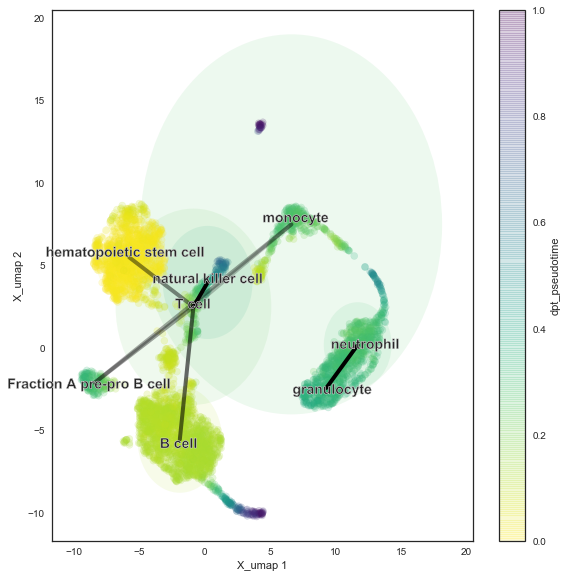

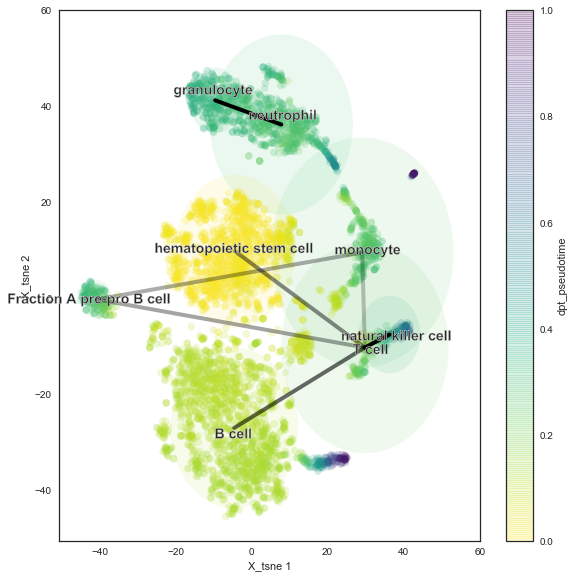

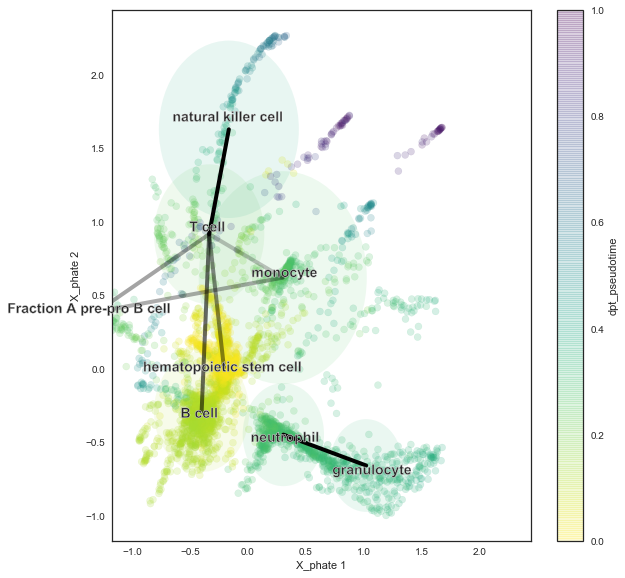

In [58]:
sns.set(style='white')

def plot_layout_paga(adata, xy_key = 'X_umap', colorby = 'dpt_pseudotime', cmap=cm.viridis_r, 
                     plot_paga = True, paga_threshold = 0.1, group_key='louvain', ax = None):
    '''
    Plot layout, optionally with minimum spanning tree overlay & pseudotime coloring
    '''
    
    if xy_key != 'X_diffmap':
        x = adata.obsm[xy_key][:,0]
        y = adata.obsm[xy_key][:,1]
    else: ## skip the 0th diffmap component
        x = adata.obsm[xy_key][:,1]
        y = adata.obsm[xy_key][:,2]

    if not ax:
        fig, ax = plt.subplots(figsize=(8,8))
        show = True
    else:
        show = False

    colorby_vals = adata.obs[colorby].values
    try: ## continuous color vals
        colorby_norm = clr.Normalize(vmin=min(colorby_vals),vmax=max(colorby_vals))
        plot_vals = plt.scatter(x,y,c=adata.obs[colorby].values, cmap=cmap, norm=colorby_norm, alpha=.2, zorder=1)
        cax = fig.colorbar(plot_vals)
        
    except: ## categorical color vals
        color_hashmap = assign_colors(pd.unique(colorby_vals),cmap=cmap)
        color_hashmap.update({'NA': (0.7,0.7,0.7,0.3)}) # plot cells w/ missing colorby vals in gray
        colors = [ color_hashmap[v] for v in colorby_vals ]
        plot_vals = plt.scatter(x,y,c=colors, alpha=.2, zorder=1)
        labels = [mpatches.Patch(color=color,label=val) for val, color in color_hashmap.items()]
        plt.legend(handles=labels)
        
        
    if plot_paga:
        assert 'paga' in adata.uns and adata.uns['paga']['groups'] == group_key, 'Oops. Run this first: sc.tl.paga(adata, group_key=%s)'%group_key
        
    groups = adata.obs[group_key].cat.categories
    group_positions = {group: find_group_center(adata, x, y, group_key, group) for group in groups}
    connections = np.triu(adata.uns['paga']['connectivities'].toarray())
    
    for group, position in group_positions.items(): ## label groups, plot approximate boundaries
        if group == 'nan': # skip missing groups
            continue
        text = plt.text(position['x']*1.05, position['y']*1.05, group, ha='center', va='center', weight='bold', fontsize=14, zorder=3)
        text.set_path_effects([path_effects.Normal(),path_effects.Stroke(linewidth=.45,foreground='white'),])
            
        try:
            c = cmap(calc_median_pseudotime(adata, group_key, group))
        except:
            c = color_hashmap[group]
        circle = mpatches.Circle((position['x'], position['y']), position['r'], 
                                 fill=True, fc=c,lw=0, alpha=0.1, zorder=0)
        ax.add_patch(circle)
        
        
    for idx1, group1 in enumerate(connections): # plot connections b/n groups with certainty above set threshold
        for idx2, certainty in enumerate(group1):
            if groups[idx1] == 'nan' or groups[idx2] == 'nan':
                continue
            if certainty >= paga_threshold:
                x_i, x_f = group_positions[groups[idx1]]['x'], group_positions[groups[idx2]]['x']
                y_i, y_f = group_positions[groups[idx1]]['y'], group_positions[groups[idx2]]['y']
                plt.plot((x_i, x_f), (y_i, y_f), color='k', 
                         alpha = min(1,2*certainty),
                         lw=4, zorder=2)
    plt.tight_layout()
    ax.set_xlabel('%s 1'%xy_key)
    ax.set_ylabel('%s 2'%xy_key)
    ax.set_xlim(ax.get_ylim())
    try:
        cax.set_label(colorby)
    except:
        pass
    
    if show:
        plt.show()
    else:
        return ax

plot_layout_paga(adata, xy_key='X_umap', group_key='cell_type', colorby='dpt_pseudotime')  
plot_layout_paga(adata, xy_key='X_tsne', group_key='cell_type', colorby='dpt_pseudotime')
plot_layout_paga(adata, xy_key='X_phate', group_key='cell_type', colorby='dpt_pseudotime')

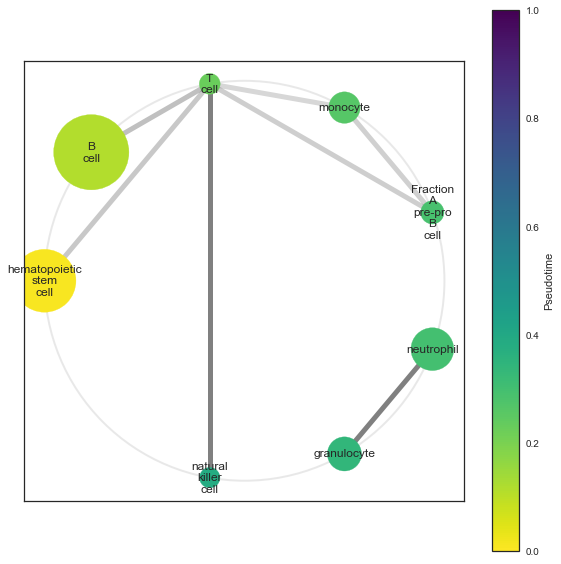

In [59]:
def plot_chord_diagram(adata, group_key, threshold = 0.1):    
    groups = sorted(list(adata.obs[group_key].cat.categories), 
                    key = lambda x: calc_median_pseudotime(adata, group_key, x))
    groups = [g for g in groups if g != 'nan']
    
    gap = 0.0#5
    radius = 100
    increment = (2*(1-gap)*np.pi) / (len(groups)+1) # angle in radians between each group (leave a 0.1*pi-sized gap in the circle for clarity)
    start_radians = np.pi
    group_radians = { }
    for g in groups:
        group_radians[g] = start_radians
        start_radians -= increment # move from left to right
        
    group_xy = { }
    for g, theta in group_radians.items():
        x = radius * np.cos(theta)
        y = radius * np.sin(theta)
        group_xy[g] = (x,y)
    
    group_sizes = pd.value_counts(adata.obs[group_key])
    group_sizes.drop('nan', inplace=True, errors='ignore')
    total_N = group_sizes.sum()
    group_sizes = group_sizes.map(lambda x: (x / total_N)*(150*radius))
    
    fig, ax = plt.subplots(figsize=(8,8))
    
    base = mpatches.Circle((0,0),radius,fill=False, ec='lightgray',lw=2, alpha=0.5,zorder=0)
    ax.add_patch(base)
    
    colorby_norm = clr.Normalize(vmin=0,vmax=1)
    x = [ group_xy[g][0] for g in groups ]
    y = [ group_xy[g][1] for g in groups ]
    s = [ group_sizes[g] for g in groups ]
    c = [ calc_median_pseudotime(adata, group_key, g) for g in groups ]
    nodes = plt.scatter(x,y,s,c,cmap=cm.viridis_r, norm=colorby_norm)
    
    for g in groups: ## Plot groups/nodes
        x,y = group_xy[g]
        ax.text(x,y,g.replace(' ', '\n'), ha='center', va='center')
        
    transitions = pd.DataFrame(np.triu(adata.uns['paga']['connectivities'].toarray()),
                               index = adata.obs[group_key].cat.categories, 
                               columns=adata.obs[group_key].cat.categories).to_dict()

    for g1 in transitions.keys(): ## Plot edges
        for g2, certainty in transitions[g1].items():
            if g1 == 'nan' or g2 == 'nan':
                continue
            if certainty >= threshold:
                ax.plot((group_xy[g1][0],group_xy[g2][0]), (group_xy[g1][1], group_xy[g2][1]),
                        alpha=min(1,0.2+certainty), c='gray', lw=5, zorder=0)

    cax = fig.colorbar(nodes) 
    cax.set_label('Pseudotime')
    plt.xticks(visible=False)
    plt.yticks(visible=False)
    ax.set_aspect(1)
    plt.tight_layout()
    
plot_chord_diagram(adata, 'cell_type')

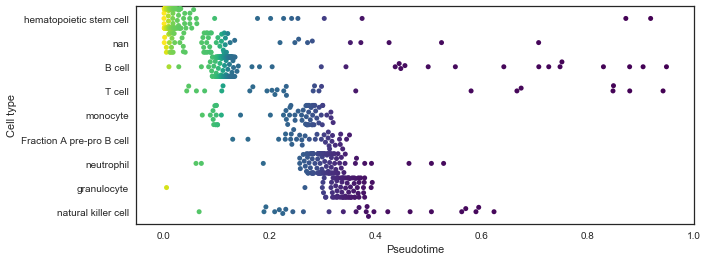

In [60]:
def downsample_by_cluster(adata, N, cluster_key = 'cell_type'):
    '''Cluster-informed downsampling of cells in an anndata object
       adata: anndata object
       proportion: proportion of cells from each cluster to KEEP
       cluster_key: where to find cluster IDs in adata.obs[]
       returns adata[subsample,:]
    '''
    assert 1 < N < len(adata.obs_names)
    assert cluster_key in adata.obs.columns.values, 'Oops. Run clustering first with sc.pp.neighbors -> sc.tl.louvain'

    total_N = len(adata.obs_names)
    clusters = adata.obs.groupby(cluster_key)
    all_selected = []

    for cluster, cells in clusters.groups.items():
        cluster_size = len(cells)
        choose_k = int(N*(cluster_size/total_N))
        selected = random.sample(list(cells), k=choose_k)
        all_selected += selected

    return adata[all_selected, :]

fig, ax = plt.subplots(figsize=(10,4))

downsampled = downsample_by_cluster(adata, N=1000, cluster_key='cell_type')
sns.swarmplot(x=downsampled.obs['dpt_pseudotime'], 
              y = downsampled.obs['cell_type'], 
              order = sorted(list(pd.unique(downsampled.obs['cell_type'])), 
                             key = lambda i: calc_median_pseudotime(downsampled, 'cell_type', i)),
              hue=downsampled.obs['dpt_pseudotime'], ax=ax, palette='viridis_r')
ax.legend_.remove()
ax.set_xlabel('Pseudotime')
ax.set_ylabel('Cell type')
plt.show()

In [61]:
''' Here I am starting to play around with how dpt and phate do their own "branch detection" as alternative(s) to 
paga's minimum spanning tree. Not looking great for phate so far, but stay tuned.'''

# x = np.linspace(0,100,50)
# lin_y = np.linspace(0,100,50)
# exp_y = np.exp(lin_y)

# print('LINEAR: should be n/a:', phate.vne.find_knee_point(lin_y, x))
# print('Exponential: should be b/n 90 and 100:', phate.vne.find_knee_point(exp_y, x))

' Here I am starting to play around with how dpt and phate do their own "branch detection" as alternative(s) to \npaga\'s minimum spanning tree. Not looking great for phate so far, but stay tuned.'

In [36]:
''' Here, I tried to save some computation time by plugging the 
precomputed diffmap distances from scanpy into the phate MDS model. 

As you can see below, the results are different enough 
(and the shortcut method's performance is poor enough) that I wouldn't recommend it.

The speedup would be negligible anyways (4-5 seconds / 1 minute total)
'''
# # neighbor_distances = adata.uns['neighbors']['distances'].toarray() ## would save 4 seconds
# # %time precomp_neighbors_phate = phate.PHATE(knn_dist='precomputed_distance').fit_transform(neighbor_distances)

# DPT = tools.dpt.DPT(adata)
# dpt_distances = OnFlySymMatrix(DPT._get_dpt_row, shape=adata.shape) 
# dpt_distance_matrix = np.array([dpt_distances[idx].copy() for idx in range(len(adata.X))]) ## would save 4 + 1 = 5 secs

# %time dpt_phate = phate.PHATE(knn_dist='precomputed_affinity').fit_transform(dpt_distance_matrix)

# cell_type_colors = assign_colors(pd.unique(adata.obs['cell_type']))
# c = [ cell_type_colors[k] for k in adata.obs['cell_type'].values ]
# plt.scatter(dpt_phate[:,0], dpt_phate[:,1], c=c)
# plt.show()
# plt.clf()
# plt.scatter(phate_coordinates[:,0], phate_coordinates[:,1], c=c)
# plt.show()
# plt.clf()

In [36]:
''' Here I tried just pulling the pairwise distances from the diffusion map values and making a parsimony-based tree.
As expected, it's way too slow for datasets > ~2000 cells'''

# DPT = tools.dpt.DPT(adata)
# dpt_distances = OnFlySymMatrix(DPT._get_dpt_row, shape=adata.shape)
# dpt_distance_matrix = np.array([dpt_distances[idx].copy() for idx in range(len(adata.X))])
# diffmap_distances = pd.DataFrame(np.triu(dpt_distance_matrix))

# diffmap_distances.to_csv('distmatrix.tmp')
# diffmap_distmatrix = dendropy.PhylogeneticDistanceMatrix.from_csv(
#         src=open("distmatrix.tmp", 'r'),
#         delimiter=",")

# diffmap_distmatrix.upgma_tree() ### wayyyy to slow for datasets over ~2000 cells (expected)

In [11]:
''' Here I tried looking at relative cell type +/- cluster frequency at each "timepoint" in pseudotime.

    While I still like this idea, I find these far more difficult to interpret than the simple stratified swarmplots above.
'''

# cell_type_pseudotime = adata.obs[['dpt_pseudotime', 'cell_type']]
# cell_type_pseudotime['dpt_pseudotime'] = adata.obs['dpt_pseudotime'].apply(lambda x: float('%.2f'%x))

# cell_type_pseudotime = cell_type_pseudotime.groupby(['dpt_pseudotime','cell_type']).size()
# cell_type_pseudotime = cell_type_pseudotime.unstack()
# cell_type_pseudotime.index.name = None
# cell_type_pseudotime.columns.name = None
# cell_type_pseudotime.fillna(0, inplace=True)
# cell_type_pseudotime.drop('nan', axis=1, inplace=True)


# def normalize_row(row):
#     total = row.sum()
#     if not np.isfinite(total):
#         return row.map(lambda x: 0)
#     else:
#         return row.map(lambda x: x / total)

# def plot_stacked_frequency(in_frequencies, norm = False, log=False):
#     fig, ax = plt.subplots(figsize=(10,6))
    
#     if norm:
#         ax.set_ylabel('Relative frequency')
#         frequencies = in_frequencies.apply(normalize_row, axis=1)
#     else:
#         ax.set_ylabel('N cells')
#         frequencies = in_frequencies
      
#     group_order = sorted(list(frequencies.columns.values), key=lambda i: frequencies[i].median())

#     group_colors = assign_colors(group_order)
    
#     x = frequencies.index.values
#     base = np.array([0 for i in x])
    
    
#     for group in group_order:
#         ax.fill_between(x, base, frequencies[group].values+base, facecolor = group_colors[group], label=group)
#         base = frequencies[group].values+base
        
#     if log and not norm:
#         plt.yscale('log')
#     ax.set_xlabel('Pseudotime')
#     plt.legend(loc=(1,.5))
#     plt.show()
# # ax.fill_between(p, c, c+inc,
# #                         facecolor=colour,
# #                         edgecolor=ec,alpha=0.4,
# #                         linestyle='-',zorder=int(clade.height*100000))

# plot_stacked_frequency(cell_type_pseudotime)
# plot_stacked_frequency(cell_type_pseudotime, log=True)
# plot_stacked_frequency(cell_type_pseudotime, norm=True)